In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
import numpy as np
import json

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)
from models.modeling_encoders import AutoEncoder

In [2]:
from utils.video import read_frames_decord
from models.modeling_encoders import AutoEncoder

# Load base model
model_path = "/work/piyush/pretrained_checkpoints/Tarsier-7b"
# model_path = "/work/piyush/pretrained_checkpoints/TARA"
device_map = "auto"
attn_implementation = 'flash_attention_2'
model_base = AutoEncoder.from_pretrained(model_path, device_map=device_map, attn_implementation=attn_implementation, use_flash_attn=False, dtype=torch.bfloat16)
su.misc.num_params(model_base.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/Tarsier-7b
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

use_flash_attn is True and Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: flash_attention_2


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


In [4]:
generate_kwargs = {
    "do_sample": False,
    "max_new_tokens": 512,
    "top_p": 1.,
    "temperature": 0.,
    "use_cache": True
}

In [95]:
jsonl_path = "/users/piyush/projects/tarsier/data/annotations/TVBench-without-NTU.jsonl"
data = su.io.load_jsonl(jsonl_path)
len(data)

2525

In [69]:
# d = data[0]
d = np.random.choice(data)

In [70]:
d

{'messages': [{'role': 'user',
   'content': [{'type': 'video',
     'video': {'video_file': '/scratch/shared/beegfs/piyush/datasets/TVBench/video/action_localization/7EJUR.mp4'}},
    {'type': 'text',
     'text': "Question: During which part of the video does the action 'person takes some food from it' occur?\n(A) At the beginning of the video.\n(B) Throughout the entire video.\n(C) In the middle of the video.\n(D) At the end of the video."}]},
  {'role': 'assistant',
   'content': [{'type': 'text', 'text': ' Answer: ('},
    {'type': 'text', 'text': '', 'reference': 'C'}]}],
 'dataset': 'TVBench/Action Localization',
 'task': 'video/QA',
 'idx': 970,
 'vid': 'action_localization/7EJUR.mp4'}

In [89]:
def generate_answer(d, n_frames=4, verbose=False):
    prompt_template = f"<video>\n<question>\nAnswer: ("
    frames_raw = read_frames_decord(d['messages'][0]['content'][0]['video']['video_file'], n_frames)
    prompt = prompt_template.replace("<question>", d['messages'][0]['content'][1]['text'])
    true_answer = d['messages'][1]['content'][-1]['reference']
    
    if verbose:
        print(prompt)
        display(su.visualize.concat_images_with_border([PIL.Image.fromarray(f.numpy()) for f in frames_raw.permute((0, 2, 3, 1))]))

    try:
    
        with torch.no_grad():
        
            pixel_values = transform_pixel_values(frames_raw) # [B, T, C, H, W]
            nframes = pixel_values.shape[1]
            # prompt = model_base.video_eol_prompt
            
            to_image = ToPILImage()
            batched_frames = []
            for batch in pixel_values:
                frames = [to_image(v) for v in batch]
                batched_frames.append(frames)
        
            generate_kwargs = {
                "max_new_tokens": 1,
                "output_hidden_states": True,
                "return_dict_in_generate": True,
            }
        
            vision_embs = []
        
            for frames in batched_frames:
                input_prompt = prompt.replace("<video>", "<image>"*len(frames))
                input_ids = model_base.processor.get_text_inputs(input_prompt)
                frames = model_base.processor.get_pixel_values(frames)
                inputs = {
                    "input_ids": input_ids,
                    "pixel_values": frames
                }
                inputs = {k:v.to(model_base.model.device) for k,v in inputs.items() if v is not None}
                outputs = model_base.model.generate(
                    **inputs,
                    **generate_kwargs,
                )
                output_text = model_base.processor.tokenizer.decode(
                    outputs[0][0][inputs['input_ids'][0].shape[0]:], skip_special_tokens=True,
                )
                if verbose:
                    print("Generated answer: ", output_text)
                    print("Actual answer: ", true_answer)
                return output_text, true_answer
    except:
        return "<error>", true_answer

In [71]:
prompt = f"<video>\n{d['messages'][0]['content'][1]['text']}\nAnswer: ("
print(prompt)

<video>
Question: During which part of the video does the action 'person takes some food from it' occur?
(A) At the beginning of the video.
(B) Throughout the entire video.
(C) In the middle of the video.
(D) At the end of the video.
Answer: (


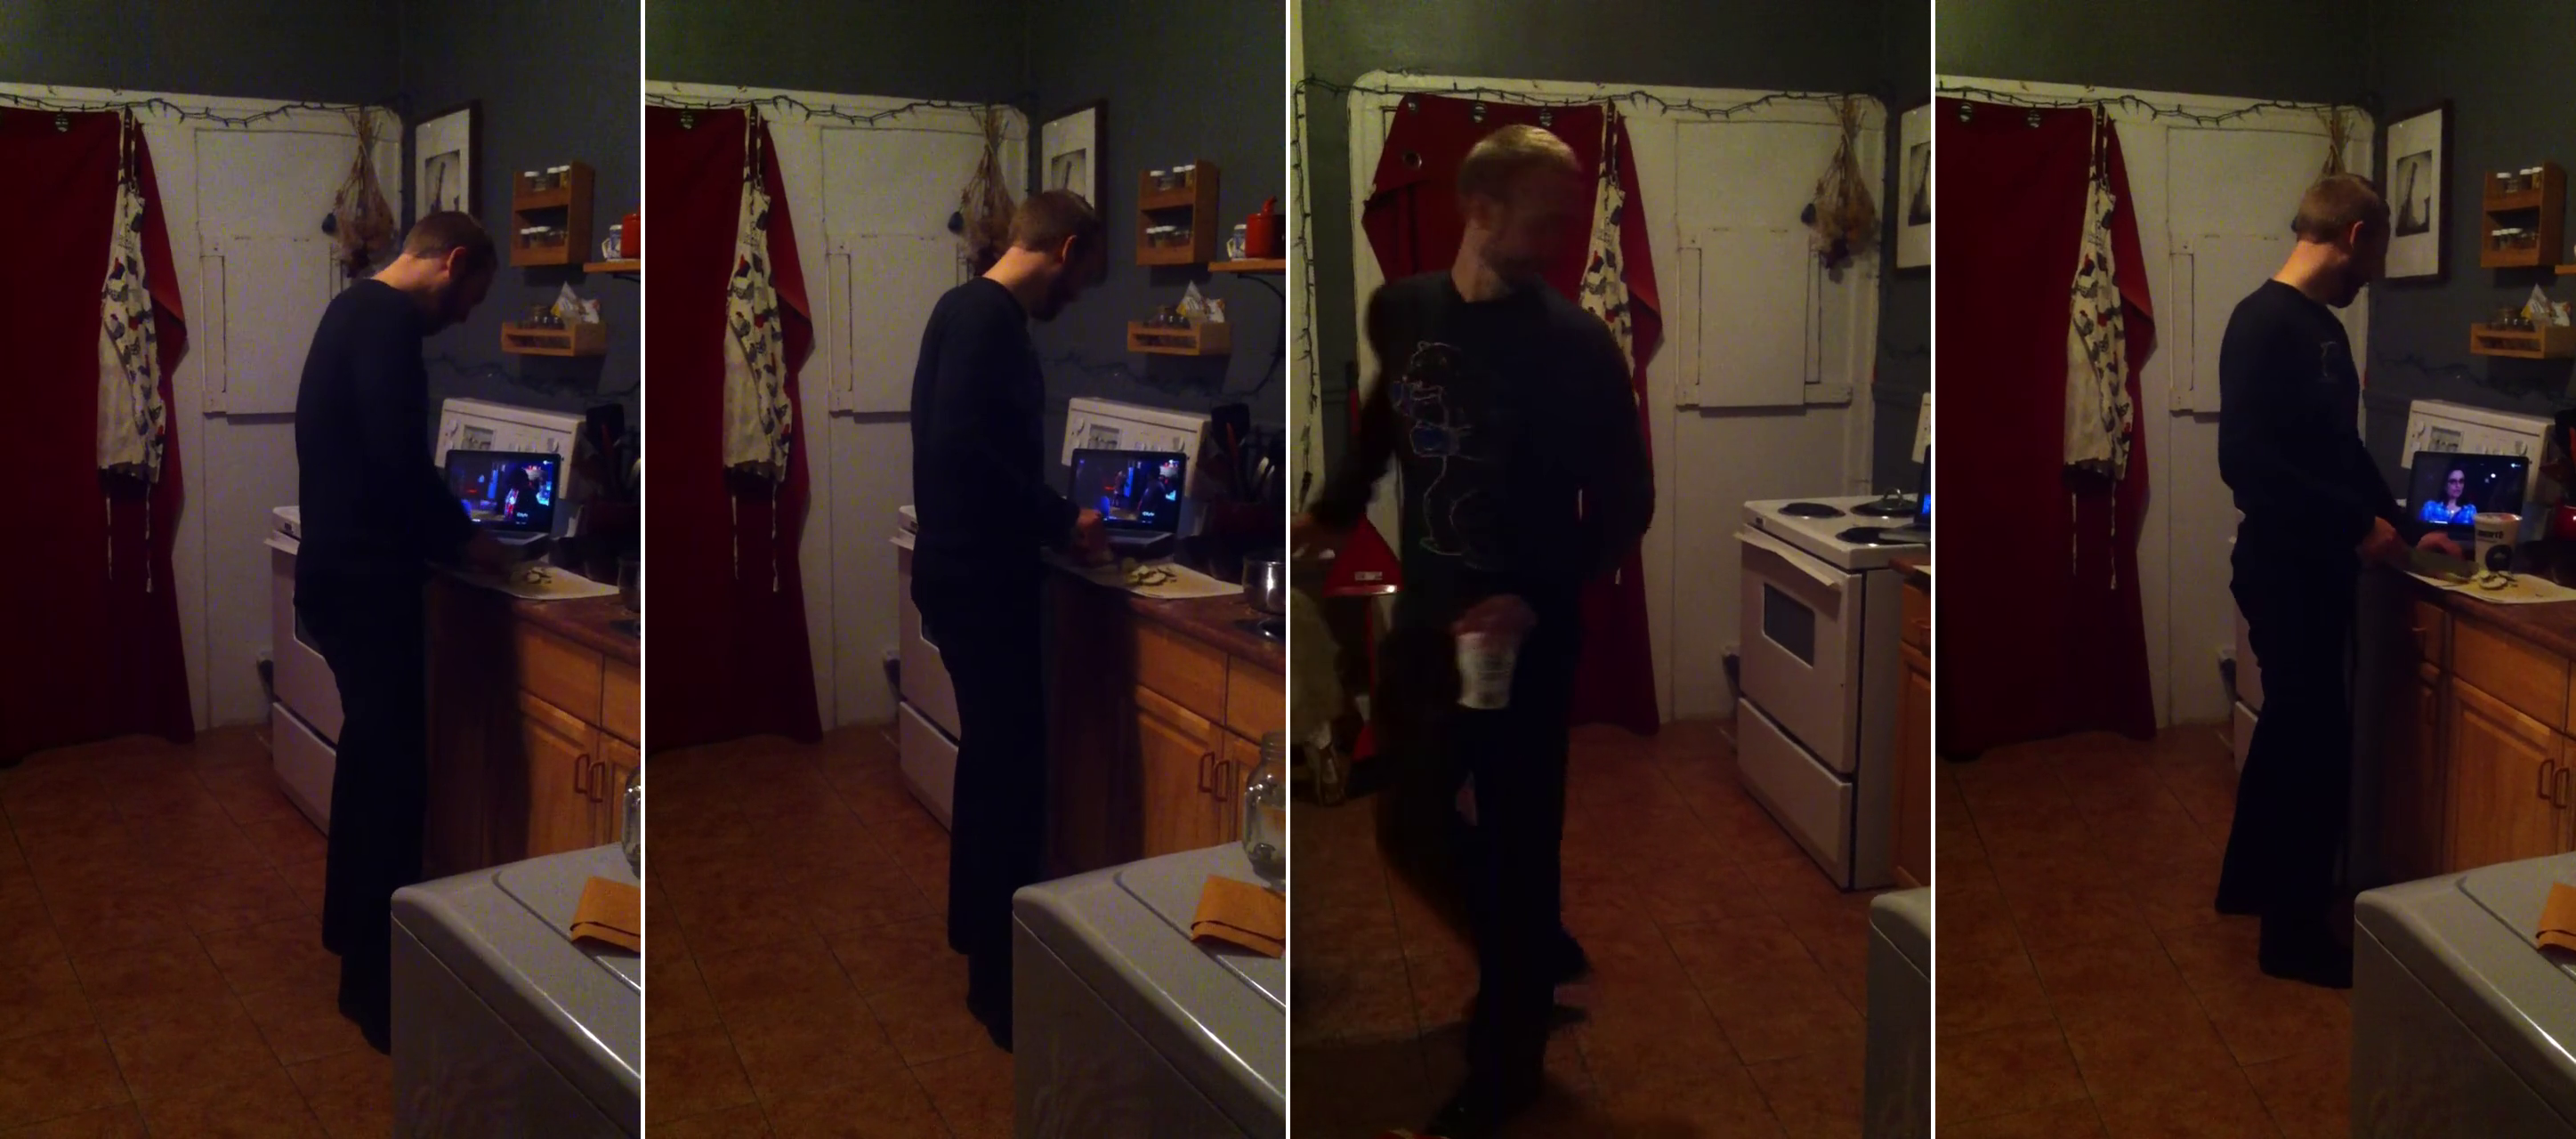

In [72]:
frames_raw = read_frames_decord(d['messages'][0]['content'][0]['video']['video_file'], 4)
su.visualize.concat_images_with_border([PIL.Image.fromarray(f.numpy()) for f in frames_raw.permute((0, 2, 3, 1))])

In [73]:
with torch.no_grad():

    pixel_values = transform_pixel_values(frames_raw) # [B, T, C, H, W]
    nframes = pixel_values.shape[1]
    # prompt = model_base.video_eol_prompt
    
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    vision_embs = []

    for frames in batched_frames:
        input_prompt = prompt.replace("<video>", "<image>"*len(frames))
        input_ids = model_base.processor.get_text_inputs(input_prompt)
        frames = model_base.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(model_base.model.device) for k,v in inputs.items() if v is not None}
        outputs = model_base.model.generate(
            **inputs,
            **generate_kwargs,
        )


In [74]:
output_text = model_base.processor.tokenizer.decode(outputs[0][0][inputs['input_ids'][0].shape[0]:], skip_special_tokens=True)
output_text

'C'

In [82]:
d['messages'][1]['content'][-1]['reference']

'C'

#### Run with $n=4$

In [ ]:
from copy import deepcopy

iterator = su.log.tqdm_iterator(range(len(data)), desc='Generating answers')
debug = False
dry_run = False
df_out = []
for i in iterator:
    d = deepcopy(data[i])
    a_pred, a_true = generate_answer(d, n_frames=4, verbose=debug)
    del d['messages']
    df_out.append(
        dict(a_pred=a_pred, a_true=a_true, **d)
    )
    if debug:
        break

    if dry_run and i == 5:
        break
df_out = pd.DataFrame(df_out)
df_out

Generating answers:   0%|          | 0/2525 [00:00<?, ?it/s]